# Tutorial 1: An introduction to event-based processing
Prepared by the International Centre for Neuromorphic Systems (ICNS) at Western Sydney University for the AMOS Conference 2023.

***UPDATE*** These tutorials have been updated and now can be run directly in Google CoLab. Click [here]( https://colab.research.google.com/github/gcohen/AMOS-Short-Course/blob/main/Tutorial1.ipynb) to open this tutorial directy in Google CoLab.

## Introduction
***What you will learn***
In this tutorial, we will work with real-world event-based data to learn how to load and process it. 

By the end of this tutorial, you will...
* Be able to load and read events from an event-based data file.
* Understand the data representation from an event-based camera and how to interact with it.
* Extract important information for the event-based data stream.
* Be able to write an iterative event-based algorithm for processing event-based data.

We'll be using the following recording for the exercises in this section:

![SegmentLocal](images/two_horses_denoised_exponential_frametime_20ms_tau_100ms.gif "segment")

This recording was chosen as it shows:

- clearly visible and identifiable objects (i.e. the horse and the person)

- the importance of motion in a visual scene - without it, the images in each static frame are not interpretable (i.e. they don't look like a horse or a person)

This tutorial aims to demonstrate this further through the following exercises.  To do these exercises, a few set-up steps are required.

## Installing on your own computer

These tutorials can now be run directly on Google CoLab, and therefore do not require you to install them locally. However, if you would like to run these tutorials on your own computer, you will need to download the repository from Github and ensure that a few Python packages are installed on your system. You will need to install ```event_stream```, a library which provides an easy method for interacting with [Event Stream](https://github.com/neuromorphic-paris/event_stream) files (formatted .es) containing data from an event-based camera.

NOTE: Event Stream is not the only file format for event-based data.  There are tools to assist in converting from other formats to ```Event Stream```, including the open-source [loris](https://github.com/neuromorphic-paris/loris) tool. However, we will exclusively use the .es file format here.

Libraries and sample code to use `Event Stream` files are available for Matlab, Python, and C++ at the [official repository](https://github.com/neuromorphicsystems/event_stream). 

For this tutorial, we will be using the Python interface.  `Event Stream` needs `numpy` to run and we will use `matplotlib` to display results.  If you do not have these installed, you will need to do use the following commands to install them:

```bash
    pip3 install numpy
```

```bash
    pip3 install matplotlib
```

Run the following command to install this library:

```bash
    pip3 install event_stream
```

**Note:** If you are using Python in `Anaconda`, `matplotlib` and `numpy` may already be installed, but it's worth checking.  If you are using `Anaconda`, don't forget to use `conda` instead of pip!!

You may get errors during the installation of the ```event_stream``` library if the installed version of ```numpy``` is not compatible. If this occurs, the easiest solution is to use a tool like ```virtualenv``` or ```conda``` to create a new virtual environment for Python.  Instructions on how to do this can be found in the README file.


Once these two tools are installed, we can begin to explore event-based data using some example data.

In [2]:
# Install the required dependencies (if not already installed). This is required to install the required packages in Google Co-Lab.
!pip3 install event_stream

In [10]:
# Download the sample data from Github
import urllib.request
filename = urllib.request.urlretrieve("https://github.com/gcohen/AMOS-Short-Course/raw/main/Data/WSU/two_horses.es", "two_horses.es")

## Testing event_stream

We will start by loading some event-based data using the ```Event Stream``` library:

In [3]:
import event_stream

decoder = event_stream.Decoder("two_horses.es")

print(f"Decoder type: {decoder.type}")
print(f"Sensor resolution: {decoder.width} x {decoder.height}")

Decoder type: dvs
Sensor resolution: 346 x 260


The code above loads the data from an event-based file and prints out some important information about the data contained within the file. 

**If this example runs, you have successfully configured your Python environment.**



## Decoders

The ```event_stream``` library uses the concepts of encoders and decoders to work with event-based files. 

**Decoders** interpret files and produce a stream of events for processing, whilst encoders write new event-based data to a data file. 

Event-based data is asynchronously generated, meaning that there is not fixed frame-rate or event-rate. The activity in the visual scene determines the number of events generated during any period. This complicates the process of saving and recalling data as the data does not appear in convenient and organised structures such as frames. In fact, we tend to store event-based in a way that allows it to be read out iteratively, event-by-event. In principle, this is how the standard decoder in ```event-stream``` operates. 

The ```decoder.type``` property shows the type of the event-based file. Whilst the underlying concepts around event-based cameras are broadly similar for all the sensors available, there are sensors that implement additional functionality which also produces data in an event-based fashion.

The most common decoder type (and the one used throughout these tutorials) is the ```dvs``` data type.

In practice, reading the data event-by-event from the file is inefficient as it incurs a significant overhead on each event. For performance reasons, we tend to buffer the data into groups of events. The ```event_stream``` decoder implements this by reading in chunks of events and then allowing you to iterate through them. 

We can explore this behaviour by interacting with the decoder as follows:

In [4]:
import event_stream

decoder = event_stream.Decoder("two_horses.es")

# Read the first chunk of events from the file. 
# The decoder is an iterator, and we can retrieve the first chunk of events by using the next function.
chunk = next(decoder)
print(f"The first chunk contains {len(chunk)} events.")

# Manually print out the first three events in this chunk
print(f"x: {chunk[0]['x']}, y: {chunk[0]['y']}, t: {chunk[0]['t']}, p: {chunk[0]['on']}")
print(f"x: {chunk[1]['x']}, y: {chunk[1]['y']}, t: {chunk[1]['t']}, p: {chunk[1]['on']}")
print(f"x: {chunk[2]['x']}, y: {chunk[2]['y']}, t: {chunk[2]['t']}, p: {chunk[1]['on']}")

The first chunk contains 12764 events.
x: 45, y: 221, t: 0, p: True
x: 80, y: 221, t: 21, p: True
x: 174, y: 220, t: 40, p: True



### Address-Event Representation (AER)

Event-based cameras output data in a format known as Address-Event Representation (AER). This format is widely used in neuromorphic systems to pass data from one system to another. The unit of data exchange in an AER system is an event, which indicates a message from a specific source, which is a specific pixel in the case of an event-based sensor.

Each AER event from the camera is represented by four values:

$e_i = [x, y, t, p]$, 

in which:
* $(x,y)$ are the coordinates of the pixel that generated the event
* $t$ is the relative timestamp at which the event occurred (in microseconds)
* $p$ is the polarity of the event (*True* for an **ON** event, *False* for an **OFF** event)

The polarity of an event indicates whether the contrast at a given pixel $(x,y)$ increased (indicated by an **ON** event) or decreased (indicated by an **OFF** event) at the time given by timestamp $t$. The timestamp for each event indicates the relative time at which the event was generated by the sensor. This is a relative timestamp with microsecond resolution. It can directly be used to measure the time between events, but is referenced to an arbitrary point in time (often, but not always, the time at which the camera was first powered on).

**Note**: The timestamps in the provided recordings start at 0. This is not always the case. Always check the the timestamp of the first event in a recording to ensure that you have the correct time offset. 

### Working with timestamps

In usual operation, you can assume that the timestamps always increase. Therefore, we can use the timestamps to easily calculate the length of the recording:

In [5]:
import event_stream
import numpy

decoder = event_stream.Decoder("two_horses.es")

# Read all the events into one large matrix
events = numpy.concatenate([packet for packet in decoder])

print(f"Total events: {len(events)}")
print(f"First timstamp: {events[0]['t']}")
print(f"Last timestamp: {events[-1]['t']}")

duration = events[-1]['t'] - events[0]['t']
print(f"Recording length: {duration / 1e6} seconds.")

Total events: 1473169
First timstamp: 0
Last timestamp: 14997554
Recording length: 14.997554 seconds.


Timestamps from an event-based recording contain a lot of useful information on their own. As event-based cameras produce events in response to visual changes in the scene, the rate at which events are generated acts as an indicator for the activity in the scene. If we plot the timestamps as a vector (i.e. against their index), we get a plot in which the gradient of the line indicates the activity in the scene. 

We can use the code below to generate a simple plot of the data in the file:

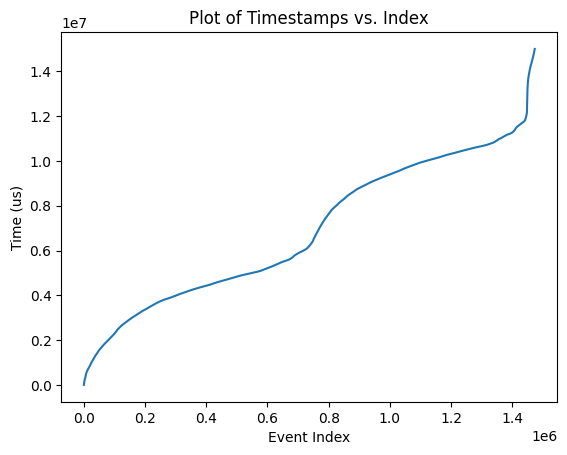

In [6]:
%matplotlib inline

import event_stream
import matplotlib.pyplot as plt

decoder = event_stream.Decoder("two_horses.es")

timestamps = []
for packet in decoder:
    for t, x, y, p in packet:
        timestamps.append(t)

plt.plot(timestamps)
plt.xlabel("Event Index")
plt.ylabel("Time (us)")
plt.title("Plot of Timestamps vs. Index")
plt.show()

### Designing algorithms for event-based processing

You may have noticed that this code is not terribly efficient. For instance, we could have plotted the curve above by loading all the events into a single matrix as we did in the prior example.  Instead, the code iterates over the events and processes events individually. This method, whilst not efficient for this data, is important in understanding the event-based nature of the data and how to process it in an event-based way. This becomes especially critical when designing and building event-based systems to run in real-time and for real-world applications.

The iterative approach above processes each event individually and in the order in which they are generated. Loading in all the data at once works for pre-recorded and offline files, but can quickly cause problems with large files or when the event-rate from the camera suddenly increases. This method also does not easily extend to real-time systems, when data needs to be processed as it is generated by the sensor. We can batch the events, but then we need to decide if we want to group them temporally (i.e. over a set period of time) or by volume (i.e. wait for a fixed number of events to occur). Both of these approaches can introduce latency and complexity into a processing system.

Iterative approaches solve many of these problems, especially when the actions performed on each event are quick to execute. They will wait if there are no events to process and can buffer events if they occur faster than they can be processed. This provides the added benefit of activity-driven processing, where data processing is only performed when events are generated. This style of processing is well suited to high-speed hardware implementations, such such as a Field Gate Programmable Array (FPGA) or dedicated neuromorphic hardware accelerators.


### Global Activity: An iterative algorithm for better event-rate visualisation 

Whilst this plot of the timestamps is interesting, it only shows the speed at which the event rates are changing. This does not give us a sense of what is happening in the data.

As it turns out, calculating a meaningful rate from non-uniformly sampled data is a hard problem. One possibility is to use time bins, but these bins cannot be shorter than the integration window. For an integration window of 200 ms, you can only generate 5 event rate samples per second, which is a very coarse approximation.

Another option is a sliding window. The approximation is much better but it requires a lot of memory (usually a First-In-First-Out (FIFO) buffer). Extending the implementation to event-based data is not a straightforward task.

To overcome this, we need to use something that calculates a value similar in meaning to the event rate, but one that can be efficiently implemented and calculated for event-based data. We call this the Global Activity Rate. To do this, we implement a simple leaky integrator in which we do the following:

* Exponentially decay the previous activity over the inter-event time interval (***delta_t***). This is the **leak**.
* Increment the activity by 1 for each event. This is the **integration**.

We implement the leak as follows:

$ activity = e^{((-\Delta t) / \tau)}$

Where $\Delta t$ is the increase in time since the last event, and $\tau$ is a fixed time interval over which we want to decay the value. We can pick $\tau$ to change the time intervals of interest. It is worth exploring the effect of changing $tau$ on the graph produced.

The beauty of this algorithm is that it uses only two memory variables (both ***floats***). This makes the algorithm much faster and memory efficient than other event-rate algorithm.

**Note:** Some of you might notice that these equations look very similar to those for a leaky-integrate-and-fire neuron model. This is because it shares the same underlying structure! If you add a threshold to trigger an action when the global activity increases beyond a certain value (with a refractory period for good measure), you end up with a full-fledged leaky integrate-and-fire neuron.

We can calculate the Global Activity using the following:

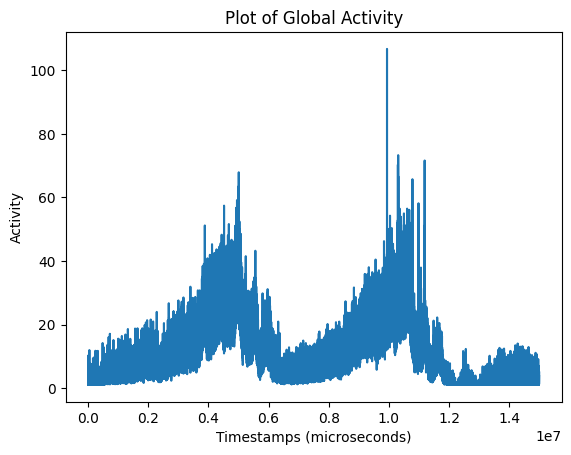

In [7]:
%matplotlib inline

import event_stream
import math
import matplotlib.pyplot as plt

decoder = event_stream.Decoder("two_horses.es")

event_activity = 0.0
previous_t = 0      # microseconds (uS)
tau = 100.0         # microseconds (uS)

ts = []
activity = []
for packet in decoder:
    for t, x, y, p in packet:
        delta_t = t - previous_t
        event_activity *= math.exp(-float(delta_t) / tau)   # Leak
        event_activity += 1                                 # Integrate
        previous_t = t
        ts.append(t)
        activity.append(event_activity)

plt.plot(ts, activity)
plt.xlabel("Timestamps (microseconds)")
plt.ylabel("Activity")
plt.title("Plot of Global Activity")
plt.show()

### A note on visualising event-based data

One of the challenges with event-based data is that the raw recordings are not in a format that is readily accessible for viewing. Unlike the output of a conventional camera, there are no straightforward ways to replay a recording. There are no mature tools for viewing, or even working, with event-based camera data. Instead, the data is often imported into a programming environment and then converted to a visual representation using custom-written scripts. The field also has not yet created any standard methods for storing, processing, or presenting data.

Frames present the most immediate and compelling method to visualise event-based data given that their format matches the output format of most monitors and displays (which are themselves frame-based). However, creating a 2D representation of event-based data requires a post-processing step that inherently discards or aggregates data and the choice of post-processing algorithm can have a significant impact on the interpretation of the data. 

**Note:** The process of generating frames from event-based data can hide important aspects of the data itself, or lend itself to incorrect interpretation of the true motion in the scene. Generating frames produces a single view on the data. Other views may exist and may be more suitable to the underlying data. This may also vary from application to application.

### Generating frames from event-based data
In this tutorial, we will explore a simple method for converting event-based data into frames. This process will render conventional frames from the event-stream and compile those into an animation or a video, allowing us to interact with the data in a familiar format. These techniques are often used to explore new event-based data, to perform quick checks on the validity of data, and to diagnose and debug algorithms. Keep in mind that this is not a complete representative of the underlying data stream.

Most methods for converting event-based data into frames makes use of the following set of steps:

1. Identify a set time interval over which to generate frames
2. Place events into time bins determined by the time intervals
3. Accumulate the events in each time bin into a 2D frame representation 
4. Collate the frame from each time interval into a video

A multitude of ways exist to perform the third step in the above process, and the choice of algorithm is highly dependent on the nature of the data to be visualise. The conversion of the list of spatio-temporal events to a 2D frame is inherently lossy. 

For our simple method, we will keep track of all the pixels that have events occurring during each time bin. We will then mark them as either containing an ON event or an OFF event based on the last event received for that pixel in each time interval. This will result in a frame for each time interval showing the pixels at which events occurred.

The following code renders simple frames from the event-stream:

In [8]:
%matplotlib notebook

import event_stream
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

decoder = event_stream.Decoder("two_horses.es")
events = np.concatenate([packet for packet in decoder])

frame_duration = 1000000    # µs
next_frame_t = 0            # µs

frame = np.zeros((decoder.width, decoder.height))
frames = []

# Generate the frames from the event stream
for t, x, y, p in events:
    if t >= next_frame_t:
        frames.append(frame)
        frame = np.zeros((decoder.width, decoder.height)) 
        next_frame_t += frame_duration
    frame[x,y] = 1 if p == True else -1

# Display the frames inline using Matplotlib Animations
fig, ax = plt.subplots()
canvas = ax.imshow(frame.T, origin='lower')
def animate(i):
    canvas.set_data(frames[i].T)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames))
from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

Exercises to try:

* Try changing the ***frame_duration*** to see the effect of increasing the frame rate on the data. 
* Try implementing an alternative frame conversion method that counts the number of events at each pixel. 
* Try blending the current frame with a weighted version of the previous frame. 

### Noise and filtering

You may have noticed that the recordings on the camera contain noise. From the event-rate curves, it is clear that the cameras generate events even when there is no explicit activity in the scene. This noise is also visible in the frames as individual events that seemingly occur randomly. Whilst there are different types of noise events,  we will examine two of them in these tutorials:

* **Spurious events** are random events from pixels that do not necessarily correspond to a contrast change.
* **Hot pixels** are noisy pixels that generate lots of events

These are caused by a variety of factors, including photodiode noise, transistor mismatch in the circuitry, internal noise in the sensor, temperature effects. The nature and cause of these noise events are an active subject of research in the neuromorphic and event-based sensor community. 

There are two main approaches for dealing with noise:

* Design algorithms that are tolerant of noise
* Filter out the noise prior to processing

In this tutorial, we will explore algorithms for pre-processing algorithms for filtering and removing these noise events.



## Neighbour support noise filtering

A popular way to remove spurious background noise events is to use a temporal neighbour support filtering algorithm. This method works by eliminating isolated events that do not occur near other event, both spatially and temporally. The algorithm is iterative and is often implemented in hardware directly. 

The algorithm works by keeping track of the last time each pixel in the camera generated an event. When a new event occurs, the neighbouring pixels are checked to see if an event occurred within an specified time window. If none of the neighbouring events have generated an event recently, the event is labelled as a noise event and discarded. If at least one of the neighbouring pixels has generated an event recently, then the pixel is said to be supported and is retained. 

This filtering process is illustrated below:

![SegmentLocal](images/noise_filtering_illustration.png "segment")

This filter is very easy to implement and works well with many scenes but it does have some drawbacks. 

Firstly, it is worth noting that this filter may incorrectly discard the first event from a valid motion across the sensor surface. In most scenes, this is not noticeable as there are usually enough subsequent events to compensate for it. However, when tracking objects such as faint stars across the sensor surface, these lost events may be significant and this filter may not be the appropriate choice. 

The time window selected for the filter is particularly important and can greatly affect the efficacy of the filtering process. A longer time window will generally keep more events.

The neighbour support noise filter can be implemented as follows


In [9]:
%matplotlib notebook

import event_stream
import numpy

time_window = 10000         # µs, a shorter time window filters more events
frame_duration = 1000000    # µs (used for plotting the events as a video)

# Read in all the events from the file
decoder = event_stream.Decoder("two_horses.es")
events = numpy.concatenate([packet for packet in decoder])

# Filter the events by examining the neighbouring four pixels to see if an event
# has occurred within the specified time_window. If so, keep that event.
ts = np.zeros((decoder.width, decoder.height))
filtered_events = []
for t, x, y, on in events:
    ts[x][y] = t
    if (
        (x > 0 and ts[x - 1][y] + time_window > t)
        or (x < decoder.width - 1 and ts[x + 1][y] + time_window > t)
        or (y > 0 and ts[x][y - 1] + time_window > t)
        or (y < decoder.height - 1 and ts[x][y + 1] + time_window > t)
    ):
        filtered_events.append((t, x, y, on))

# Print a summary of the filtering results 
print(f"Original recording contained {len(events)} events.")
print(f"Filtered recording contains {len(filtered_events)}.")
print(f"Reduced by { ((len(events) - len(filtered_events)) / len(events)) * 100 }%")


# Generate the frames from the event stream
next_frame_t = 0            # µs
frame = numpy.zeros((decoder.width, decoder.height))
frames = []
for t, x, y, p in filtered_events:
    if t >= next_frame_t:
        frames.append(frame)
        frame = numpy.zeros((decoder.width, decoder.height)) 
        next_frame_t += frame_duration
    frame[x,y] = 1 if p == True else -1

# Display the frames inline using Matplotlib Animations
fig, ax = plt.subplots()
plt.title("Filtered Event Frames")
canvas = ax.imshow(frame.T, origin='lower')
def animate(i):
    canvas.set_data(frames[i].T)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames))
from IPython.display import HTML
HTML(ani.to_jshtml())

RuntimeError: the file 'data/two_horses.es' could not be open for reading

Exercises to try:
* Implement the full search of the 3x3 and 4x4 area around the event. Numpy array slicing can perform this operation very efficiently.
* Explore requiring more than one pixel of support when filtering. 

### An event-based filtering pipeline

Finally, the above filter can be used to build an entirely event-based building block that ingests events and emits events. In the code below, the `event_stream` library is used to both read the events and to write the filtered events out to a new file. Once this is done, other algorithms can then operate on the filtered events without any knowledge of the upstream processing. 

In [ ]:
import event_stream
import numpy

time_window = 1000  # µs, a shorter time window filters more events

decoder = event_stream.Decoder("two_horses.es")
encoder = event_stream.Encoder(
    "two_horses_denoised.es", decoder.type, decoder.width, decoder.height
)

ts = [[-time_window] * decoder.height for _ in range(0, decoder.width)]

for packet in decoder:
    new_packet = []
    for t, x, y, on in packet:
        ts[x][y] = t
        if (
            (x > 0 and ts[x - 1][y] + time_window > t)
            or (x < decoder.width - 1 and ts[x + 1][y] + time_window > t)
            or (y > 0 and ts[x][y - 1] + time_window > t)
            or (y < decoder.height - 1 and ts[x][y + 1] + time_window > t)
        ):
            new_packet.append((t, x, y, on))
    encoder.write(numpy.array(new_packet, dtype=event_stream.dvs_dtype))